In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from functions import *
from data_cleaning import DataCleaning

from betfairlightweight import StreamListener, APIClient
import os


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
df = pd.read_csv('../data/raw_proform/2024_09_28.csv')

df.head()

,Race Time,Course,Distance (y),Race Type,Official Going,Classifications,Position,Horse,Jockey Claim,Weight (pounds),SP Odds Decimal,BF Decimal SP,"Won (1=Won, 0=Lost)",PRC Average,PRC Last Run,PRC 2nd Last Run,PRC 3rd Last Run,Pace Rating,OR,Tissue Odds Decimal,Main,Main Stats,Stats,Trn Stats,Jky Stats,TrnJky Stats,Hrs Stats,HA Career Speed Rating,HA Last 1 Year Speed Rating,MR Career Speed Rating,MR Last 1 Year Speed Rating,MR Last 3 Runs Speed Rating,LTO Speed Rating,2nd LTO Speed Rating,3rd LTO Speed Rating,4th LTOt Speed Rating,Evening Price,Breakfast Price,Morning Price,dyHA,dyLTO,dyAVG,dyAVG(x),dyMR,dyMR(x),dy2HA,Finished Races SR,WON SR Before,Won P/L Before,Plc SR Before,DSLR(F),DSLR(J),FLAT TURF Runs Before,FLAT AW Runs Before,CHASE Runs Before,HURDLE Runs Before,NHF Runs Before,ALL FLAT Runs Before,FLAT TURF Wins Before,FLAT AW Wins Before,CHASE Wins Before,HURDLE Wins Before,NHF Wins Before,Distance In Yards LTO,Official Rating LTO,Distance To Winner LTO,Betfair SP Odds LTO (Decimcal),Speed Rating LTO,PRC Average LTO,PRC Last Run LTO,PRC 2nd Last Run LTO,PRC 3rd Last Run LTO,Cherry Picked Rating,Today's Going Wins,Today's Going Places,Today's Going Runs,Today's Distance Wins,Today's Distance Places,Today's Distance Runs,Today's Class Wins,Today's Class Places,Today's Class Runs,Today's Course Wins,Today's Course Places,Today's Course Runs,Heavy/Soft Ground Wins,Heavy/Soft Ground Places,Heavy/Soft Ground Runs,Good to Soft Ground Wins,Good to Soft Ground Runs,Good Ground Wins,Good Ground Runs,Good to Firm Ground Wins,Good to Firm Ground Runs
0,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,1,Selby's Pride,0,124,2.25,2.42,1,61,85,64,34,4,75,4.33,340,578,238,76,75,71,16,50,50,48,48,48,50,48,44,0,1.73,1.83,2.00,50.0,50.0,47.0,47.0,48.0,48.0,48.0,NaN,0.00,-3.0,33.33,19.0,NaN,3,0,0,0,0,3,0,0,0,0,0,1100,0.0,0.30,46.00,50.0,49.0,64.0,34.0,0.0,NaN,0,1,1,0,1,3,0,1,3,0,0,0,0,0,1,0,0,0,1,0,1
1,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,2,Lucy Lulu,3,130,2.75,2.89,0,75,78,74,72,8,76,3.25,374,748,374,90,92,92,100,68,68,57,57,63,68,63,55,55,3.25,2.75,2.88,68.0,68.0,58.0,62.0,57.0,63.0,63.0,NaN,16.67,9.0,16.67,10.0,NaN,6,0,0,0,0,6,1,0,0,0,0,1337,75.0,3.80,11.39,68.0,77.0,74.0,72.0,84.0,NaN,0,0,0,1,1,5,1,1,2,0,0,0,0,1,3,0,1,0,0,1,2
2,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,3,Prayer Matt,0,124,15.00,20.34,0,44,44,0,0,0,0,9.00,298,628,330,86,87,77,80,40,40,40,40,40,40,0,0,0,26.00,29.00,29.00,40.0,40.0,40.0,40.0,40.0,40.0,NaN,NaN,0.00,-1.0,0.00,106.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1317,0.0,7.20,37.81,40.0,0.0,0.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,4,Ardom's Lady,0,124,26.00,29.00,0,27,27,0,0,0,0,9.00,293,609,316,90,81,87,58,39,39,39,39,39,39,0,0,0,34.00,29.00,26.00,39.0,39.0,39.0,39.0,39.0,39.0,NaN,NaN,0.00,-1.0,0.00,22.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1100,0.0,13.55,49.73,39.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,5,Lady Ardad,0,124,6.50,9.00,0,40,40,0,0,2,0,5.50,329,661,332,85,88,87,72,48,48,48,48,48,48,0,0,0,8.00,7.50,6.50,48.0,48.0,48.0,48.0,48.0,48.0,NaN,NaN,0.00,-1.0,0.00,16.0,NaN,1,0,0,0,0,1,0,0,0,0,0,1103,0.0,4.20,12.00,48.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [3]:
bins = [800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600,
        2800, 3000, 3200, 3400, 3600, 3800, 4000]

df['distance_bucket'] = pd.cut(df['Distance (y)'], bins = bins,
                               labels=['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000',
                                       '2000-2200', '2200-2400', '2400-2600', '2600-2800', '2800-3000',
                                       '3000-3200', '3200-3400', '3400-3600', '3600-3800', '3800-4000'])

In [4]:
df['evening_morning_price'] = (df['Morning Price'] / df['Evening Price'])

df['breakfast_morning_price'] = (df['Morning Price'] / df['Breakfast Price'])

In [5]:
df['weight'] = df['Weight (pounds)'] - df['Jockey Claim']

In [6]:
print(df.dtypes)

Race Time                           object
Course                              object
Distance (y)                         int64
Race Type                           object
Official Going                      object
Classifications                     object
Position                             int64
Horse                               object
Jockey Claim                         int64
Weight (pounds)                      int64
SP Odds Decimal                    float64
BF Decimal SP                      float64
Won (1=Won, 0=Lost)                  int64
PRC Average                          int64
PRC Last Run                         int64
PRC 2nd Last Run                     int64
PRC 3rd Last Run                     int64
Pace Rating                          int64
OR                                   int64
Tissue Odds Decimal                float64
Main                                 int64
Main Stats                           int64
Stats                                int64
Trn Stats  

In [7]:
list = df.columns.tolist()

In [8]:
list

['Race Time',
 'Course',
 'Distance (y)',
 'Race Type',
 'Official Going',
 'Classifications',
 'Position',
 'Horse',
 'Jockey Claim',
 'Weight (pounds)',
 'SP Odds Decimal',
 'BF Decimal SP',
 'Won (1=Won, 0=Lost)',
 'PRC Average',
 'PRC Last Run',
 'PRC 2nd Last Run',
 'PRC 3rd Last Run',
 'Pace Rating',
 'OR',
 'Tissue Odds Decimal',
 'Main',
 'Main Stats',
 'Stats',
 'Trn Stats',
 'Jky Stats',
 'TrnJky Stats',
 'Hrs Stats',
 'HA Career Speed Rating',
 'HA Last 1 Year Speed Rating',
 'MR Career Speed Rating',
 'MR Last 1 Year Speed Rating',
 'MR Last 3 Runs Speed Rating',
 'LTO Speed Rating',
 '2nd LTO Speed Rating',
 '3rd LTO Speed Rating',
 '4th LTOt Speed Rating',
 'Evening Price',
 'Breakfast Price',
 'Morning Price',
 'dyHA',
 'dyLTO',
 'dyAVG',
 'dyAVG(x)',
 'dyMR',
 'dyMR(x)',
 'dy2HA',
 'Finished Races SR',
 'WON SR Before',
 'Won P/L Before',
 'Plc SR Before',
 'DSLR(F)',
 'DSLR(J)',
 'FLAT TURF Runs Before',
 'FLAT AW Runs Before',
 'CHASE Runs Before',
 'HURDLE Runs Befor

In [9]:
remove = ['Race Time', 'Course', 'Distance (y)', 'Race Type', 'Official Going',
       'Classifications', 'Position', 'Horse', 'Jockey Claim',
       'Weight (pounds)','distance_bucket']

list1 = [x for x in list if x not in remove]

In [11]:
normalized_df = DataCleaning.normalize_columns(df, list1)

normalized_df.head(5)

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,Race Time,Course,Distance (y),Race Type,Official Going,Classifications,Position,Horse,Jockey Claim,Weight (pounds),SP Odds Decimal,BF Decimal SP,"Won (1=Won, 0=Lost)",PRC Average,PRC Last Run,PRC 2nd Last Run,PRC 3rd Last Run,Pace Rating,OR,Tissue Odds Decimal,Main,Main Stats,Stats,Trn Stats,Jky Stats,TrnJky Stats,Hrs Stats,HA Career Speed Rating,HA Last 1 Year Speed Rating,MR Career Speed Rating,MR Last 1 Year Speed Rating,MR Last 3 Runs Speed Rating,LTO Speed Rating,2nd LTO Speed Rating,3rd LTO Speed Rating,4th LTOt Speed Rating,Evening Price,Breakfast Price,Morning Price,dyHA,dyLTO,dyAVG,dyAVG(x),dyMR,dyMR(x),dy2HA,Finished Races SR,WON SR Before,Won P/L Before,Plc SR Before,DSLR(F),DSLR(J),FLAT TURF Runs Before,FLAT AW Runs Before,CHASE Runs Before,HURDLE Runs Before,NHF Runs Before,ALL FLAT Runs Before,FLAT TURF Wins Before,FLAT AW Wins Before,CHASE Wins Before,HURDLE Wins Before,NHF Wins Before,Distance In Yards LTO,Official Rating LTO,Distance To Winner LTO,Betfair SP Odds LTO (Decimcal),Speed Rating LTO,PRC Average LTO,PRC Last Run LTO,PRC 2nd Last Run LTO,PRC 3rd Last Run LTO,Cherry Picked Rating,Today's Going Wins,Today's Going Places,Today's Going Runs,Today's Distance Wins,Today's Distance Places,Today's Distance Runs,Today's Class Wins,Today's Class Places,Today's Class Runs,Today's Course Wins,Today's Course Places,Today's Course Runs,Heavy/Soft Ground Wins,Heavy/Soft Ground Places,Heavy/Soft Ground Runs,Good to Soft Ground Wins,Good to Soft Ground Runs,Good Ground Wins,Good Ground Runs,Good to Firm Ground Wins,Good to Firm Ground Runs,distance_bucket,evening_morning_price,breakfast_morning_price,weight
0,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,1,Selby's Pride,0,124,0.002480,0.001400,1.0,0.616162,0.858586,0.646465,0.343434,0.333333,0.543478,0.006461,0.924211,0.773714,0.675351,0.860465,0.844720,0.807947,0.577889,0.555556,0.561798,0.571429,0.558140,0.558140,0.561798,0.539326,0.494382,0.000000,0.000819,0.000933,0.001126,0.543478,0.561798,0.559524,0.559524,0.571429,0.558140,0.545455,NaN,0.0000,0.258084,0.3333,0.001993,NaN,0.019608,0.0,0.0,0.0,0.0,0.016304,0.000000,0.0,0.0,0.0,0.0,0.145618,0.000000,0.000998,0.045954,0.561798,0.494949,0.646465,0.343434,0.000000,NaN,0.0,0.066667,0.019608,0.000000,0.023256,0.018987,0.000000,0.030303,0.027273,0.0,0.0,0.00000,0.0,0.000000,0.025,0.0,0.00,0.0,0.019608,0.000000,0.027778,1000-1200,0.148561,0.161716,0.356164
1,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,2,Lucy Lulu,3,130,0.003480,0.001870,0.0,0.757576,0.787879,0.747475,0.727273,0.666667,0.550725,0.004301,0.995789,0.968000,0.947896,0.941860,0.950311,0.947020,1.000000,0.755556,0.764045,0.678571,0.662791,0.732558,0.764045,0.707865,0.617978,0.617978,0.002548,0.001980,0.002127,0.739130,0.764045,0.690476,0.738095,0.678571,0.732558,0.715909,NaN,0.1667,0.287370,0.1667,0.000996,NaN,0.039216,0.0,0.0,0.0,0.0,0.032609,0.052632,0.0,0.0,0.0,0.0,0.176992,0.460123,0.012646,0.011379,0.764045,0.777778,0.747475,0.727273,0.848485,NaN,0.0,0.000000,0.000000,0.058824,0.023256,0.031646,0.055556,0.030303,0.018182,0.0,0.0,0.00000,0.0,0.083333,0.075,0.0,0.04,0.0,0.000000,0.090909,0.055556,1000-1200,0.110476,0.154064,0.397260
2,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,3,Prayer Matt,0,124,0.027981,0.019320,0.0,0.444444,0.444444,0.000000,0.000000,0.000000,0.000000,0.015803,0.835789,0.830857,0.859719,0.918605,0.919255,0.847682,0.899497,0.444444,0.449438,0.476190,0.465116,0.465116,0.449438,0.000000,0.000000,0.000000,0.028430,0.031843,0.031843,0.434783,0.449438,0.476190,0.476190,0.476190,0.465116,NaN,NaN,0.0000,0.262965,0.0000,0.011625,NaN,0.006536,0.0,0.0,0.0,0.0,0.005435,0.000000,0.0,0.0,0.0,0.0,0.174345,0.000000,0.023960,0.037772,0.449438,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.009091,0.0,0.0,0.00000,0.0,0.000000,0.000,0.0,0.00,0.0,0.019608,0.000000,0.000000,1000-1200,0.142820,0.146135,0.356164
3,31/08/2021 1:00:00 PM,Ripon,1100,Turf,Good,Nov-Fil,4,Ardom's Lady

In [18]:
X = normalized_df.drop(['Race Time', 'Course', 'Horse', 'Distance (y)', 'Race Type', 'Official Going', \
                        'Classifications', 'Position', 'Horse', 'Jockey Claim', 'Weight (pounds)', 'Won (1=Won, 0=Lost)', 'distance_bucket', 'SP Odds Decimal', \
                            'Evening Price', 'Breakfast Price', 'Morning Price'], axis = 1)
y = normalized_df[['Won (1=Won, 0=Lost)']]

X.fillna(0, inplace = True)

In [20]:
X.columns

Index(['BF Decimal SP', 'PRC Average', 'PRC Last Run', 'PRC 2nd Last Run',
       'PRC 3rd Last Run', 'Pace Rating', 'OR', 'Tissue Odds Decimal', 'Main',
       'Main Stats', 'Stats', 'Trn Stats', 'Jky Stats', 'TrnJky Stats',
       'Hrs Stats', 'HA Career Speed Rating', 'HA Last 1 Year Speed Rating',
       'MR Career Speed Rating', 'MR Last 1 Year Speed Rating',
       'MR Last 3 Runs Speed Rating', 'LTO Speed Rating',
       '2nd LTO Speed Rating', '3rd LTO Speed Rating', '4th LTOt Speed Rating',
       'dyHA', 'dyLTO', 'dyAVG', 'dyAVG(x)', 'dyMR', 'dyMR(x)', 'dy2HA',
       'Finished Races SR', 'WON SR Before', 'Won P/L Before', 'Plc SR Before',
       'DSLR(F)', 'DSLR(J)', 'FLAT TURF Runs Before', 'FLAT AW Runs Before',
       'CHASE Runs Before', 'HURDLE Runs Before', 'NHF Runs Before',
       'ALL FLAT Runs Before', 'FLAT TURF Wins Before', 'FLAT AW Wins Before',
       'CHASE Wins Before', 'HURDLE Wins Before', 'NHF Wins Before',
       'Distance In Yards LTO', 'Official Rating

/Users/andrewbarwise/miniforge3/envs/horse_trading/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


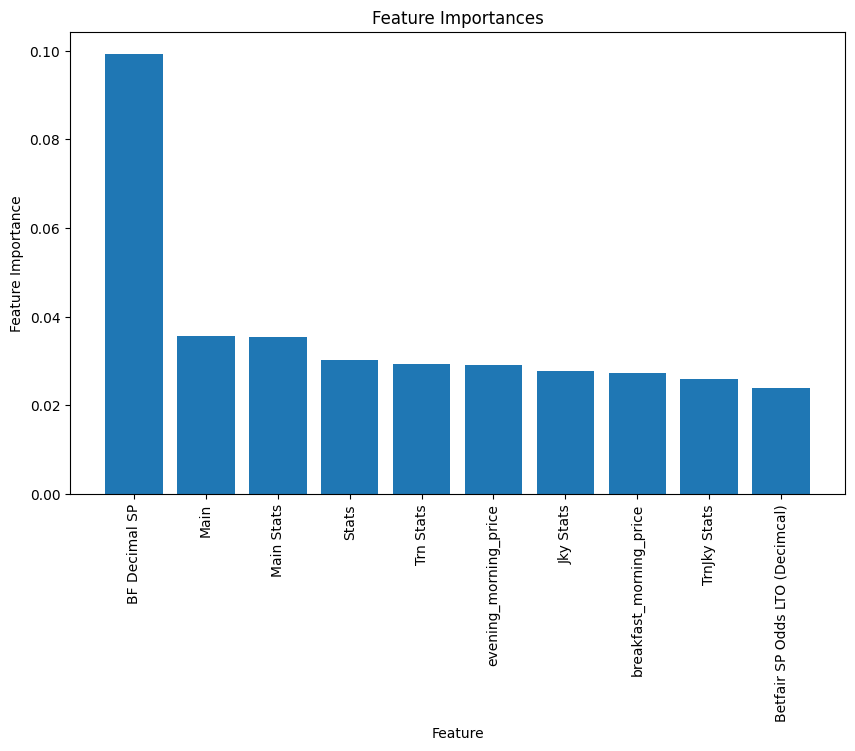

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:10]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.show()